In [1]:
%load_ext memory_profiler
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
import os
import numpy as np
import h5py
from pathlib import Path
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Classifying Lattice Type with CNNs an Diffuse Multiple Scattering Data

Diffuse multiple scattering (DMS) is a relatively new X-ray scattering
technique. Multiple scattering of X-rays due to disruption in the long-range
order of a crystal results in distinct lines of high-intensity being produced.
These DMS lines contain rich information about the crystal structure including
information about structure type and lattice parameters.

In this example we take as input a DMS sample produced by a crystal in an
unknown orientation and classify the lattice type based on the line pattern
produced. We perform classification on a binary sample, which can be either a
Monoclinic or a Tetragonal crystal.

## Loading Data

First we need to load the data from disk. We have already split the data into training and validation sets for you and save them into two HDF files. The two files contain a total of `8060` DMS images, and corresponding one-hot encoded labels identifying the image as either being of the monoclinic or tetragonal crystal lattice. Here is some helper code to provide a generator to load the data from the HDF files.

The number of images is too large to load into memory on the small system we're using for this tutorial. Instead we will use a tensorflow dataset to load data from disk on the fly, without loading it all to RAM.

In [2]:
IMG_HEIGHT = 487
IMG_WIDTH = 195
N_CHANNELS = 1

def hdf_generator(path, buffer_size=320):
    """ Load data DMS data from disk
    
    Args:
        path: path of the HDF file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels
            
dataset = tf.data.Dataset.from_generator(lambda: hdf_generator(path='data/dms/train.h5'), 
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), (None,)))

validation_dataset = tf.data.Dataset.from_generator(lambda: hdf_generator(path='data/dms/test.h5'), 
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), (None,)))

dataset, validation_dataset

(<FlatMapDataset shapes: ((None, 487, 195, 1), (None,)), types: (tf.float32, tf.float32)>,
 <FlatMapDataset shapes: ((None, 487, 195, 1), (None,)), types: (tf.float32, tf.float32)>)

We can plot a selection of examples from the dataset:

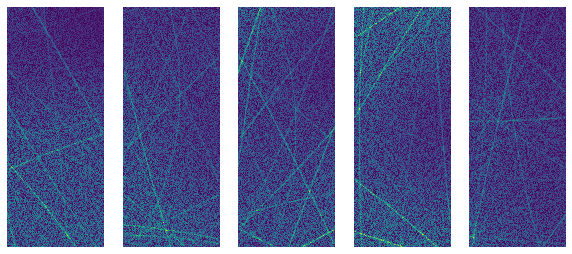

In [24]:
examples = list(dataset.take(5))

fig, axes = plt.subplots(1, 5, figsize=(10, 20))
for ax, (example, label) in zip(axes, examples):
    ax.matshow(example[0, ..., 0])
    ax.axis('off')

The two `tf.data.Dataset`s with generate batches of size `320`. We can use the `unbatch` command to remove the outermost dimension from our dataset. Then rebatch the images to the desired batch size.

**Exercise**: Use the [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) methods to:
1. unbatch the training & validation datasets
2. shuffle the training dataset with a buffer size of `500`
3. batch both datasets with a batch size of `32`

In [3]:
dataset = dataset.unbatch().shuffle(500).batch(32)
validation_dataset = validation_dataset.unbatch().batch(32)

## Creating a Model

**Exercise**: Create a CNN model using the tensorflow keras API that has the following archiecture:

 - Conv2D with 8 filters
     - ReLU activation
     - 8 filters
 - MaxPool2D 
 - Conv2D with 16 filters 
     - ReLU activation
     - 8 filters
 - MaxPool2D
 - Flatten 
 - Dense
     - ReLU activation
     - 8 units
 - Dense
     - ReLU activation
     - 8 units
 - Dense
     - sigmoid activation
     - 1 unit
     
We've written some skeleton code below to get you started.

In [4]:
def cnn_model(img_height, img_width, n_channels=1, n_classes=1):
    """
    A CNN for classifying DMS lattice types
    Args:
        img_height: the height of the image in pixels (int)
        img_width: the width of the image in pixels (int)
    n_classes: number of clsses
    Returns:
        model: a Keras model
    """
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(8, kernel_size=(5, 5),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(img_height, img_width, n_channels)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal',))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal',))
    model.add(tf.keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal',))
    model.add(tf.keras.layers.Dense(n_classes, activation='sigmoid', kernel_initializer='he_normal'))
    return model


Run your model below. You should see that it starts training and will show you the loss and accuracy for both the training and validation datasets. 
 
 - What training accuracy do you get?
 - What validation accuracy do you get?
 
**Exercise**: 
 - Modify your network architecture to include batch normalization or dropout layers. What affect does this have on the validation accuracy?
 - Modify your network to apply some data augmentation. How does this affect you results.

In [7]:
def run_model():
    n_classes = 1
    batch_size=20
    val_steps = 500
    samples = 15000
    epochs=50
    nworkers = 4
    channels = 3

    model = cnn_model(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, n_classes=n_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalseNegatives()])
    model.fit(dataset, validation_data=validation_dataset, epochs=1)
    
%memit run_model()

202/202 [==============================] - 8s 39ms/step - loss: 0.7894 - accuracy: 0.5327 - true_positives_2: 1199.0000 - false_positives_2: 1535.0000 - true_negatives_2: 2236.0000 - false_negatives_2: 1478.0000 - val_loss: 0.8499 - val_accuracy: 0.4963 - val_true_positives_2: 424.0000 - val_false_positives_2: 575.0000 - val_true_negatives_2: 376.0000 - val_false_negatives_2: 237.0000
peak memory: 5657.27 MiB, increment: 5.95 MiB
